<a href="https://colab.research.google.com/github/RanojoyBiswas/PySpark-Practice/blob/main/Linear_Regression_Consulting_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Consulting Project

Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis! 

Once you've created the model and tested it for a quick check on how well you can expect it to perform, make sure you take a look at why it performs so well!

In [ ]:
pip install pyspark

In [ ]:
# spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Cons_Lin').getOrCreate()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Pyspark Practice/Python-and-Spark-for-Big-Data-master/Spark_for_Machine_Learning/Linear_Regression/cruise_ship_info.csv',
                    inferSchema = True, header = True)

In [ ]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [ ]:
for i in df.head(5):
  print(i,'\n')

Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55) 

Row(Ship_name='Quest', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55) 

Row(Ship_name='Celebration', Cruise_line='Carnival', Age=26, Tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7) 

Row(Ship_name='Conquest', Cruise_line='Carnival', Age=11, Tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1) 

Row(Ship_name='Destiny', Cruise_line='Carnival', Age=17, Tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0) 



In [ ]:
df.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       null|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     null|       null| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

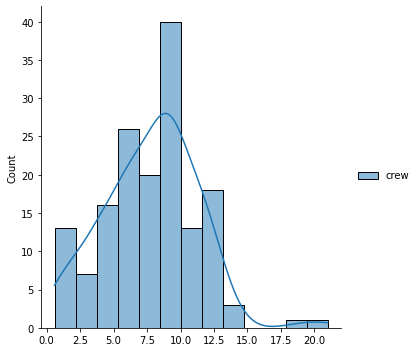

In [ ]:
# crew column
sns.displot(df.select('crew').toPandas(), kde= True)
plt.show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|  Royal_Caribbean|   23|
|         Carnival|   22|
|         Princess|   17|
| Holland_American|   14|
|        Norwegian|   13|
|            Costa|   11|
|        Celebrity|   10|
|              MSC|    8|
|              P&O|    6|
|             Star|    6|
|Regent_Seven_Seas|    5|
|        Silversea|    4|
|         Seabourn|    3|
|         Windstar|    3|
|           Cunard|    3|
|          Oceania|    3|
|          Crystal|    2|
|          Azamara|    2|
|           Disney|    2|
|           Orient|    1|
+-----------------+-----+



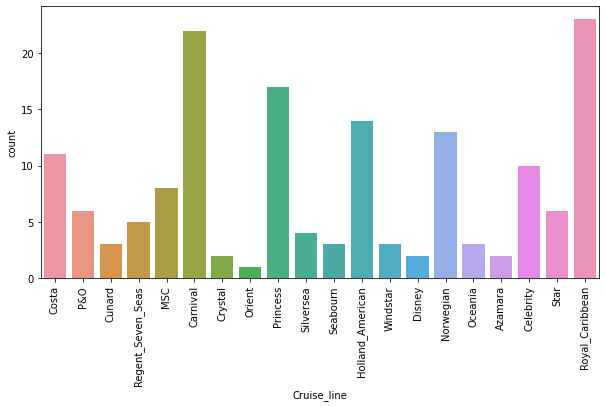

In [ ]:
# Cruise_line feature ---> Count of each Cruise_line
df.groupBy('Cruise_line').count().orderBy('count', ascending = False).show()
cl_df = df.groupBy('Cruise_line').count().toPandas()

plt.figure(figsize = (10,5))
sns.barplot(x = 'Cruise_line', y = 'count', data = cl_df)
# rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=90)
# show the plot
plt.show()

In [ ]:
# dealing with categorical feature 'Cruise_line'
from pyspark.ml.feature import StringIndexer

encoder = StringIndexer(inputCol = 'Cruise_line',
                        outputCol = 'Cruise_line_indexed')
encoded = encoder.fit(df).transform(df)

encoded.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_indexed|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|                1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|                1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|                1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.5

In [ ]:
encoded.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew',
 'Cruise_line_indexed']

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
assembler = VectorAssembler(inputCols = ['Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'Cruise_line_indexed'], outputCol = 'features')

all_features = assembler.transform(encoded)

In [ ]:
data = all_features.select(['features', 'crew'])

In [ ]:
# scaling the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol = 'features', outputCol='scaled_features', withMean = True, withStd = True)
scaled_data = scaler.fit(data).transform(data)

In [ ]:
# after scaling features
final_data = scaled_data.select(['scaled_features', 'crew'])
final_data.show()

+--------------------+----+
|     scaled_features|crew|
+--------------------+----+
|[-1.2723564208380...|3.55|
|[-1.2723564208380...|3.55|
|[1.35380052876893...| 6.7|
|[-0.6158171834363...|19.1|
|[0.17202990144577...|10.0|
|[0.82856913884752...| 9.2|
|[-0.0905857935149...| 9.2|
|[0.95987698632787...| 9.2|
|[0.43464559640647...| 9.2|
|[-1.2723564208380...|11.5|
|[-0.7471250309166...|11.6|
|[1.61641622372963...| 6.6|
|[0.30333774892612...| 9.2|
|[0.17202990144577...| 9.2|
|[-0.6158171834363...| 9.3|
|[-1.0097407258773...|11.6|
|[-0.8784328783970...|10.3|
|[-0.0905857935149...| 9.2|
|[-0.4845093359559...| 9.3|
|[0.56595344388682...| 9.2|
+--------------------+----+
only showing top 20 rows



In [ ]:
# train-test split
train_data, test_data = final_data.randomSplit([0.7,0.3])

In [ ]:
train_data.describe().show()
test_data.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               114|
|   mean| 7.944210526315801|
| stddev|3.6771063784065734|
|    min|              0.59|
|    max|              21.0|
+-------+------------------+

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|                44|
|   mean| 7.405454545454546|
| stddev|3.0115409441598087|
|    min|              0.59|
|    max|              12.0|
+-------+------------------+



In [ ]:
# importing Linear Regression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'scaled_features', labelCol='crew')

In [ ]:
# training linear model
model = lr.fit(train_data)

# model intercept and coefficients
print(f'Model Coefficients : {model.coefficients}')
print(f'Model Intercept : {model.intercept}')

Model Coefficients : [-0.12825227202109626,0.5292770493451763,-1.5574268281544024,0.7168822327216288,3.799515448161428,-0.06315203033830483,0.2546001328998126]
Model Intercept : 7.772020311982774


In [ ]:
test_res = model.evaluate(test_data)
type(test_res)

pyspark.ml.regression.LinearRegressionSummary

In [ ]:
print(f'Mean Squared Error : {test_res.meanSquaredError}')
print(f'Root Mean Squared Error : {test_res.rootMeanSquaredError}')
print(f'Mean Absolute Error : {test_res.meanAbsoluteError}')
print(f'R-Squared Value : {test_res.r2}')
print(f'Adj R-Squared Value : {test_res.r2adj}')

Mean Squared Error : 0.5596461475560189
Root Mean Squared Error : 0.7480950123854716
Mean Absolute Error : 0.5330163163250562
R-Squared Value : 0.9368577293784491
Adj R-Squared Value : 0.9245800656464809


In [ ]:
unlabeled_data = test_data.select('scaled_features')
pred = model.transform(unlabeled_data)

joined = test_data.join(pred, 'scaled_features')
joined.show()

+--------------------+-----+------------------+
|     scaled_features| crew|        prediction|
+--------------------+-----+------------------+
|[-1.4036642683184...|  8.0|    9.300660247779|
|[-1.2723564208380...| 3.55| 4.408698195962266|
|[-1.2723564208380...|  9.0|10.130789164401275|
|[-1.2723564208380...| 11.5|11.045032929658875|
|[-1.2723564208380...| 10.9|11.235939573533393|
|[-1.0097407258773...| 11.6|12.123743439687683|
|[-0.8784328783970...| 10.0|    9.538838029305|
|[-0.8784328783970...| 11.6|12.110900081957727|
|[-0.7471250309166...|  7.0| 7.307241263152261|
|[-0.7471250309166...|  9.0| 8.798084566225986|
|[-0.6158171834363...|  7.6| 7.432617637360405|
|[-0.6158171834363...| 11.0|10.044808434363208|
|[-0.6158171834363...|  9.0|  9.20927745026278|
|[-0.4845093359559...|  0.6| 0.646173942053685|
|[-0.4845093359559...|  6.8| 6.686199937130313|
|[-0.4845093359559...|10.29|  9.47011232408521|
|[-0.4845093359559...| 8.68| 8.818793100614919|
|[-0.4845093359559...| 9.99| 9.218201704

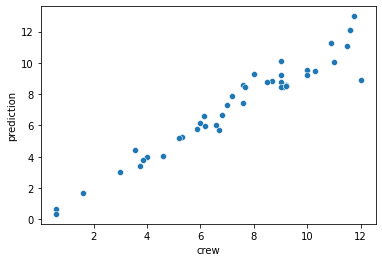

In [ ]:
df_pd = joined.select('crew', 'prediction').toPandas()

# Create scatter plot using seaborn
sns.scatterplot(data=df_pd, x='crew', y='prediction')
plt.show()

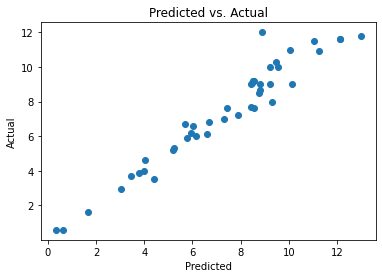

In [ ]:
# Extract the actual and predicted values from the dataframe
actual = joined.select('crew').rdd.flatMap(lambda x: x).collect()
predicted = joined.select('prediction').rdd.flatMap(lambda x: x).collect()

# Create a scatter plot of predicted vs. actual values
plt.scatter(predicted, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual')
plt.show()

In [ ]:
from pyspark.sql.functions import corr

In [ ]:
df.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [ ]:
# coorelation between crew and tonnage
df.select(corr('crew', 'Tonnage')).show()

+-------------------+
|corr(crew, Tonnage)|
+-------------------+
|  0.927568811544939|
+-------------------+



In [ ]:
# coorelation between crew and cabins
df.select(corr('crew', 'cabins')).show()

+------------------+
|corr(crew, cabins)|
+------------------+
|0.9508226063578497|
+------------------+



In [ ]:
# coorelation between crew and passengers
df.select(corr('crew', 'passengers')).show()

+----------------------+
|corr(crew, passengers)|
+----------------------+
|    0.9152341306065384|
+----------------------+

